<h1>House Prices - Novas técnicas de regressão</h1>

Adaptado do kernel <a href='https://www.kaggle.com/apapiu/regularized-linear-models'>Regularized Linear Models</a> do Alexandre Papiu e do kernel <a href='https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe'>TOP 2%</a> do Laurens Ten Cate.

<h3>Importante</h3>

Pacotes necessários:
<ul>
    <li>xgboost</li>
    <li>lightgbm</li>
    <li>mlxtend</li>
    <li>catboost</li>
</ul>
Para que o notebook rode normalmente esses pacotes devem ser instalados.

In [1]:
# !pip install xgboost
# !pip install catboost
# !pip install mlxtend
# !pip install lightbgm

<h3>Para futuras melhorias</h3>

<ul>
    <li>Tunar os melhores algoritmos</li>
    <li>Melhorar pré-processamento tratando dados perdidos e outliers por classe</li>
    <li>Fazer análise exploratória para identificar distribuições que não se adequam aos algoritmos</li>
    <li>Usar redes neurais</li>
</ul>

# Warnings de convergência

Alguns modelos não vão conseguir atingir a convergência com o número padrão de iterações. O warning a seguir desativa os avisos de não convergência. Caso quiser mostrá-los, não execute a célula abaixo.

In [2]:
import warnings
warnings.filterwarnings('ignore')

<h3>Importando bibliotecas</h3>

In [3]:
# estrutura de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# estatistica
from scipy.stats import skew
from scipy.stats import pearsonr

# metricas
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import explained_variance_score # EVS

# normalizador
from sklearn.preprocessing import scale

# treino teste
from sklearn.model_selection import train_test_split

# modelos
# linear models
from sklearn.linear_model import Ridge, LinearRegression, Lars, BayesianRidge, Perceptron, SGDRegressor
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV, OrthogonalMatchingPursuit, ARDRegression
from sklearn.linear_model import PassiveAggressiveClassifier, TheilSenRegressor, HuberRegressor, GammaRegressor

# tree models
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor

# svm models
from sklearn.svm import LinearSVR, NuSVR, SVR

# closed neural network models
from sklearn.neural_network import MLPRegressor

# ensemble models
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# others
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# stack
from mlxtend.regressor import StackingCVRegressor


<h3> Carregando os dados </h3>

In [4]:
# carregando treino e teste
train = pd.read_csv('../datasets/housing_prices/train.csv')
test = pd.read_csv('../datasets/housing_prices/test.csv')

<h3>EDA com estatísticas</h3>

In [5]:
# train.shape

In [6]:
# train.head()

In [7]:
# train.describe()

In [8]:
# train.columns

In [9]:
# train.info()

In [10]:
# test.shape

In [11]:
# test.head()

In [12]:
# test.describe()

In [13]:
# test.columns

In [14]:
# test.info()

<h3>Preprocessando os dados</h3>

In [15]:
# juntando os dados para prepocessamento
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

In [16]:
# aplicando log(x + 1) no target para obter distribuição de frequência mais próxima da normal
train["SalePrice"] = np.log1p(train["SalePrice"])

In [17]:
# log(x+1) nas features númericas para obter distribuição de fequência mais próxima da normal

# selecionando features numéricas
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# calculando skew (assimetria)
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
# filtro por skew maior que 0.75 (perto de zero é normal)
skewed_feats = skewed_feats[skewed_feats > 0.75]
# selecionando índices para normalização
skewed_feats = skewed_feats.index
# normalizando por log(x + 1)
all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) 

In [18]:
# aplicando dummies
all_data = pd.get_dummies(all_data)

In [19]:
# preenchendo nulos com média
all_data = all_data.fillna(all_data.mean())

In [20]:
# criando treino
X = all_data[:train.shape[0]] # treino

# criando o teste
test = all_data[train.shape[0]:] # teste

# criando o target
y = train.SalePrice # target

# normalizando treino e teste
# X = scale(X)
# test = scale(test)

<h3>Criando tabela de resultados</h3>

In [21]:
results = {
    "Model":[],
    "MAE":[],
    "RMSE":[],
    "EVS":[]
}

<h3>Treino e teste</h3>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

<h3>Modelos</h3>

In [23]:
model_instances = [
    # LINEAR
    (Ridge(), "Ridge"), 
    (RidgeCV(), "Ridge CV"),
    (LassoCV(), "LASSO CV"),
    (LinearRegression(), "Linear Regression"),
    (BayesianRidge(), "Bayesian Rigde"),
    (ElasticNet(), "Elastic Net"),
    (OrthogonalMatchingPursuit(), "Orthogonal Matching Pursuit"),
    (ARDRegression(), "ARD Regression"),
    # TREE
    (ExtraTreeRegressor(), "Extra Tree"),
    (DecisionTreeRegressor(), "Decision Tree"),
    # SVM
    (LinearSVR(max_iter=100), "Linear SVR"),
    (NuSVR(max_iter=100), "NuSVR"),
    (SVR(max_iter=100), "SVR"),
    # NN
    (MLPRegressor(max_iter=100, activation='tanh'), "MLPRegressor"), # 1000 and 10000 hasn't converged
    # BOOST
    (AdaBoostRegressor(), "Ada boost"),
    (BaggingRegressor(), "Bagging"),
    (GradientBoostingRegressor(n_estimators=700), "Gradient Boosting"),
    (RandomForestRegressor(), "Random Forest"),
    # State of Art
    (XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,nthread=4,scale_pos_weight=1,
                     reg_alpha=0.00006), "XGBoost"),
    (LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,verbose=0,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11), "LightGBM"),
    (CatBoostRegressor(verbose=False), "CatBoost"),
]

In [24]:
for model, model_name in model_instances:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results['Model'].append(model_name)
    results['MAE'].append(mean_absolute_error(y_test, y_pred))
    results['RMSE'].append(mean_squared_error(y_test, y_pred, squared=True))
    results['EVS'].append(explained_variance_score(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [25]:
results = pd.DataFrame(results)
results

,Model,MAE,RMSE,EVS
0,Ridge,0.085518,0.015530,0.910454
1,Ridge CV,0.087248,0.015933,0.908089
2,LASSO CV,0.137400,0.037580,0.782970
3,Linear Regression,0.087932,0.018624,0.892788
4,Bayesian Rigde,0.086697,0.015821,0.908744
5,Elastic Net,0.199856,0.077648,0.552586
6,Orthogonal Matching Pursuit,0.097677,0.018175,0.895573
7,ARD Regression,0.086128,0.014851,0.914232
8,Extra Tree,0.161913,0.050602,0.707893
9,Decision Tree,0.151826,0.042559,0.754219


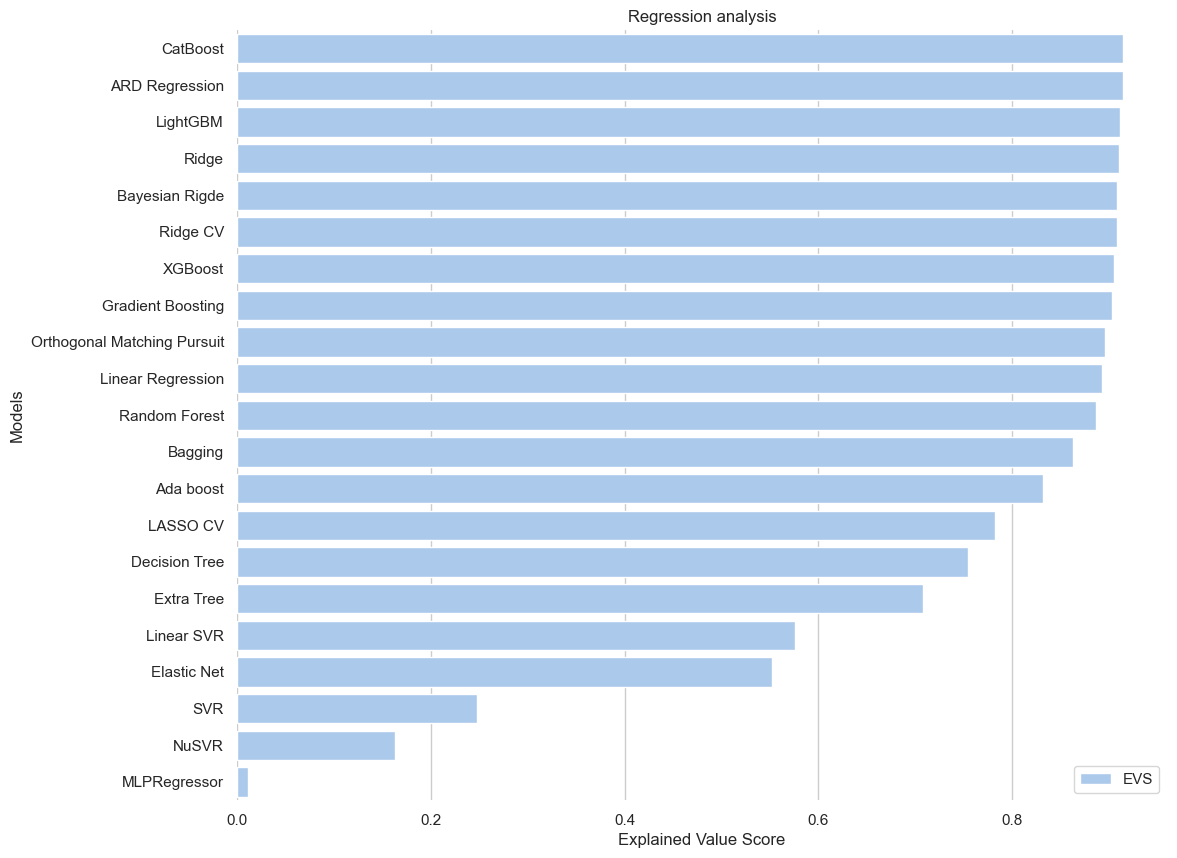

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
results_temp = results.sort_values("EVS", ascending=False)
sns.barplot(x="EVS", y="Model", data=results_temp,
            label="EVS", color="b")
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Models",
       xlabel="Explained Value Score",title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

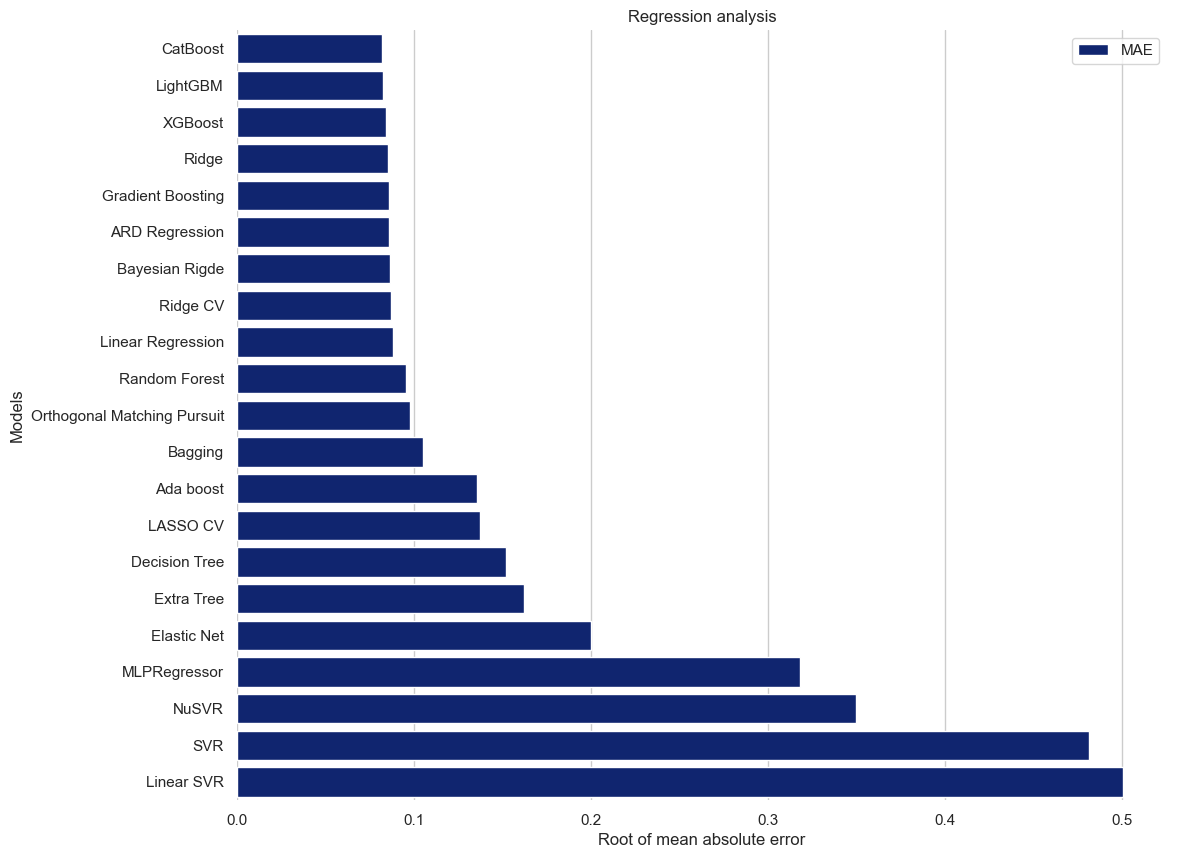

In [27]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Plot the total crashes
sns.set_color_codes("dark")
results_temp = results.sort_values("MAE", ascending=True)
sns.barplot(x="MAE", y="Model", data=results_temp,
            label="MAE", color="b")
# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="Models",
       xlabel="Root of mean absolute error",title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

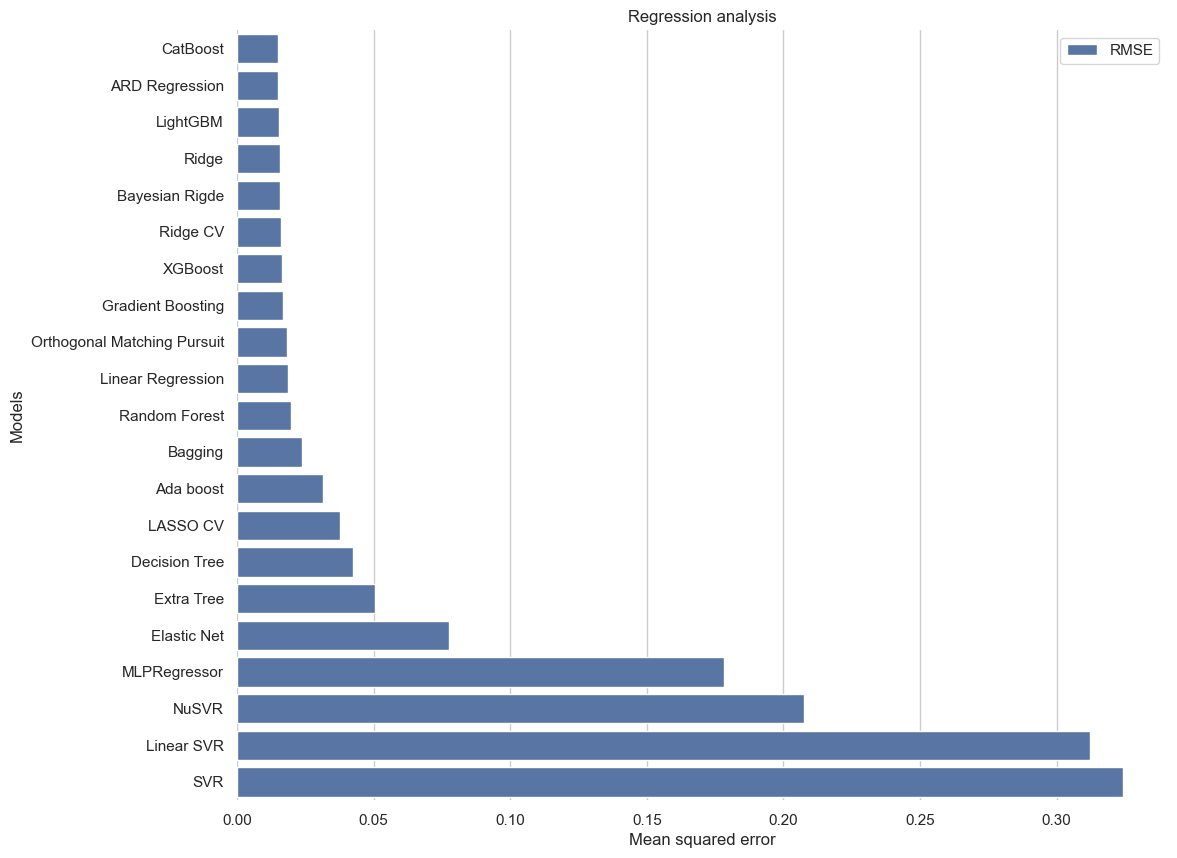

In [28]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Plot the total crashes
sns.set_color_codes()
results_temp = results.sort_values("RMSE", ascending=True) # just the 8 first.iloc[:8]
sns.barplot(x="RMSE", y="Model", data=results_temp,
            label="RMSE", color="b")
# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="Models",
       xlabel="Mean squared error",title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

In [29]:
results_temp = results.sort_values("EVS", ascending=False)
results_temp.iloc[:5]["Model"]

20          CatBoost
7     ARD Regression
19          LightGBM
0              Ridge
4     Bayesian Rigde
Name: Model, dtype: object

In [30]:
results_temp = results.sort_values("MAE", ascending=True)
results_temp.iloc[:5]["Model"]

20             CatBoost
19             LightGBM
18              XGBoost
0                 Ridge
16    Gradient Boosting
Name: Model, dtype: object

In [31]:
results_temp = results.sort_values("RMSE", ascending=True)
results_temp.iloc[:5]["Model"]

20          CatBoost
7     ARD Regression
19          LightGBM
0              Ridge
4     Bayesian Rigde
Name: Model, dtype: object

# Submissão para o Kaggle

In [33]:
model = CatBoostRegressor()
model.fit(X, y, verbose=False)
y_pred = model.predict(test)

In [36]:
sample_submission = pd.read_csv("../datasets/housing_prices/sample_submission.csv",index_col=0)
sample_submission['SalePrice'] = np.expm1(y_pred)
sample_submission.to_csv("catboost_submission.csv")

<b>Kaggle Public Score:</b> 0.12687

# Stacking

Escolhemos então  algoritmos para tunagem:
<ul>
    <li>Cat</li>
    <li>ARD Regression</li>
    <li>Light GBM</li>
</ul>

In [45]:
cat = CatBoostRegressor(verbose=False)

light = LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, verbose=0,
                                      min_sum_hessian_in_leaf = 11)

ard = ARDRegression()

#stack
stack_gen=StackingCVRegressor(
    regressors=(cat,light,ard),
    meta_regressor=light,
    use_features_in_secondary=True)

In [48]:
stack_gen.fit(X.values,y.values)
stack_gen_preds = stack_gen.predict(test.values)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

# Submissão com Stacking

In [50]:
sample_submission = pd.read_csv("../datasets/housing_prices/sample_submission.csv",index_col=0)
sample_submission['SalePrice'] = np.expm1(stack_gen_preds)
sample_submission.to_csv("stack_gen_preds.csv")

<b>Kaggle Public Score:</b> 0.12188

# Avaliação do modelo CatBoost por validação cruzada

In [57]:
from sklearn.model_selection import cross_val_score

model = CatBoostRegressor(verbose=False)

SG_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE", np.sqrt(-SG_scores.mean()))

RMSE 0.13174877265821425


In [59]:
# Valores em cada etapa
np.sqrt(-SG_scores)

array([0.11980049, 0.16504409, 0.14204513, 0.11718808, 0.10624087])

Fonte: https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

<img src="../assets/cross_validation.png">

# Exercícios

Considere a competição:

https://www.kaggle.com/competitions/playground-series-s3e1

Tente buscar bons modelos e fazer um Stack dos 3 melhores encontrados. Seu último score melhorou?

# Atividade avaliativa 2

## Problema de regressão supervisionada.

https://www.kaggle.com/competitions/playground-series-s3e8

- 00-04 será proporcional à 0000-4305
- 04-07 será proporcional à 4305-2505
- 07-10 será proporcional à 2505-0582

### Dicas

- Começe por um baseline constante, submetendo a mediana para todos os casos testes, por exemplo;
- Faça uma limpeza simples dos dados, por exemplo, removendo as variáveis categóricas e treine um modelo, por exemplo o Random Forest;
- Faça uma limpeza mais profunda, codifique as categóricas e resolva o problema da simetria das numéricas, aplique também log na variável de interesse;
- Busque os melhores modelos;
- Faça um stack dos melhores modelos;